In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sympy
import scipy
from scipy.interpolate import *
from numpy.polynomial.polynomial import Polynomial
rng = np.random.default_rng()

In [2]:
class Interpolation:
    def __init__(self,X,Y):
        if len(X) == len(X):
            self.X = X  # X, Y is random info for interpolation.
            self.Y = Y
            self.x = np.array([])  # x is arranged test points to predict \hat{y} and to plot
            self.y = np.array([])
            self.time = 0
        else:
            ValueError("dimension wrong")
    def plot(self, ax, plotColor = "C0", scatterColor = "C1"):
        ax.plot(self.x, self.y, color = plotColor, label = "prediction line")
        ax.scatter(self.X,self.Y, color = scatterColor, label="data")
        ax.legend()
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(self.method +('; using time: %.2gs'% self.time))
        
class polyInter(Interpolation):
    def __init__(self, X, Y):
        super().__init__(X, Y)
        self.coef = np.array([])
        self.method="Polynomial Interpolation"
    def solve(self):
        A = np.column_stack([pow(self.X,n) for n in range(len(self.X))])
        self.coef = np.linalg.solve(A, self.Y)  
        return self.coef
    def result(self, x):
        t0 = time.time()
        self.solve()
        self.x = x
        self.y = np.column_stack([pow(self.x, n) \
                                  for n in range(len(self.coef))])@self.coef
        t1 = time.time()
        self.time = t1 - t0
        return self.y

    
class nevilleInter(Interpolation):
    def __init__(self, X, Y):
        super().__init__(X, Y)
        self.method="Neville Interpolation"
    def solve(self, xSingle):
        ansMatrix = np.zeros((len(self.X), len(self.Y)))
        ansMatrix[0,:] = self.Y
        for i in range(1, len(self.X)):
            for j in range(len(self.X) - i):
                ansMatrix[i,j] = \
                1/(self.X[j] - self.X[j+i])*\
                ((xSingle - self.X[j+i])*ansMatrix[i-1,j]-\
                (xSingle - self.X[j])*ansMatrix[i-1,j+1])
        return ansMatrix[-1,0]
    def result(self, x):
        t0 = time.time()
        self.x = x
        ufuncSolve = np.frompyfunc(self.solve,1,1)
        self.y = ufuncSolve(x)
        t1 = time.time()
        self.time = t1 - t0
        return self.y

    
class rationalInter(Interpolation):
    def __init__(self,X,Y):
        super().__init__(X,Y)
        self.n=len(self.X)
        self.method="Rational Function Interpolation"
    def result(self,x_test):
        t0 = time.time()
        self.x = np.array(x_test)
        self.y = []
        for x in x_test:
            t=sympy.Symbol("t")
            inv_quotient=np.zeros((self.n,self.n))
            inv_quotient[:,0]=self.Y
            for i in range(self.n):
                for j in range (i+1,self.n):
                    inv_quotient[j,i+1]=(self.X[j]-self.X[i])/(inv_quotient[j,i]-inv_quotient[i,i])
            c=np.diag(inv_quotient)
            self.rational_frac=c[-1]
            for i in range(self.n-1):
                 self.rational_frac=(c[self.n-2-i]+(t-self.X[self.n-2-i])/self.rational_frac)
            self.y.append(self.rational_frac.subs(t,x))
        self.y = np.array(self.y)
        t1 = time.time()
        self.time = t1 - t0
        return self.y
class lagrangeInter(Interpolation):
    def __init__(self, X, Y):
        super().__init__(X, Y)
        self.method="Scipy Lagrange Interpolation"    
    def result(self, x):
        t0 = time.time()
        self.x = x
        poly = lagrange(X, Y)
        self.y = Polynomial(poly.coef[::-1])(self.x)
        t1 = time.time()
        self.time = t1 - t0
        return self.y
class barycentricInter(Interpolation):
    def __init__(self, X, Y):
        super().__init__(X, Y)
        self.method="Scipy Barycentric Interpolation"    
    def result(self, x):
        t0 = time.time()
        self.x = x
        interFun = scipy.interpolate.BarycentricInterpolator(self.X,self.Y)
        self.y = interFun.__call__(self.x)
        t1 = time.time()
        self.time = t1 - t0
        return self.y
        
        
        

In [3]:
def fun(x):
    return np.log(x)+x**2/20+np.sin(x)
X = 2*np.pi*rng.random(13)
Y = fun(X)
x = np.linspace(0,2*np.pi,100)

/var/folders/19/_3__wm5j79qg185xqr0nw0m80000gn/T/ipykernel_2124/444359478.py:2: RuntimeWarning: divide by zero encountered in log
  return np.log(x)+x**2/20+np.sin(x)


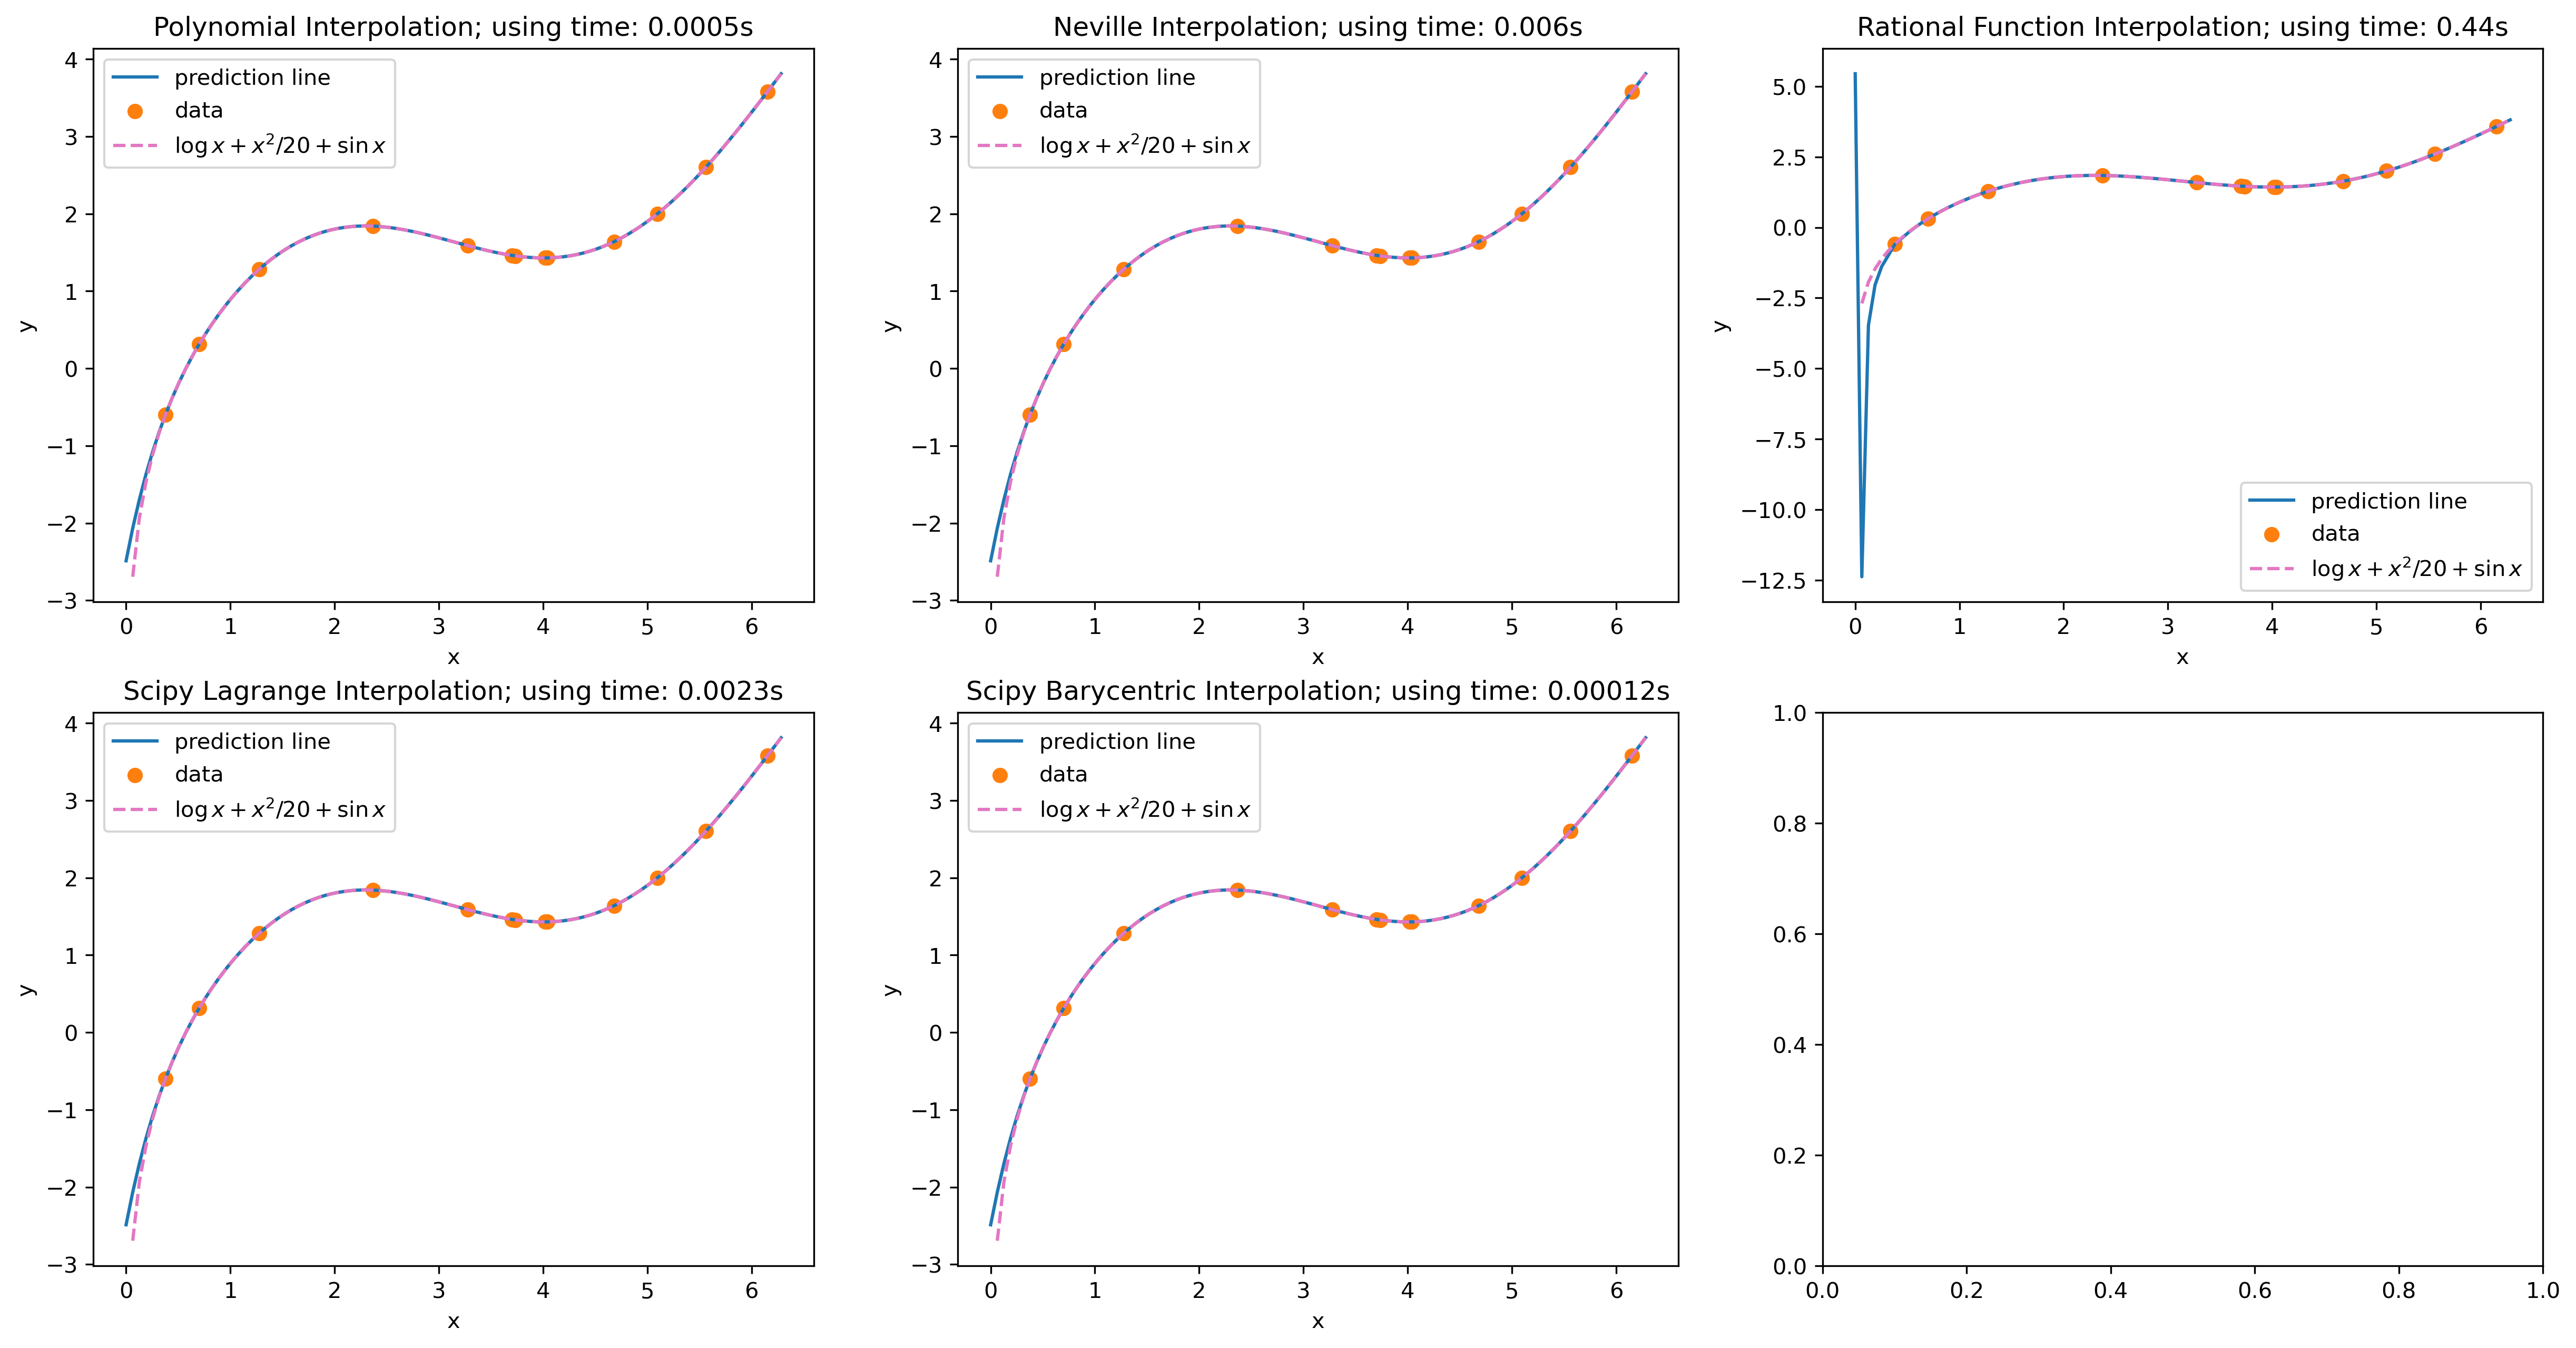

In [4]:
inter1 = polyInter(X,Y)
inter2 = nevilleInter(X,Y)
inter3 = rationalInter(X,Y)
inter4 = lagrangeInter(X,Y)
inter5 = barycentricInter(X,Y)

interTest = [inter1,inter2,inter3,inter4,inter5]
fig, axs = plt.subplots(2,3,figsize=(20,10), dpi = 300)
for i in range(len(interTest)):
    interTest[i].result(x)
    interTest[i].plot(axs.ravel()[i])
    axs.ravel()[i].plot(x,fun(x),color = 'C6',linestyle = '--',label = r'$\log{x}+x^2/20+\sin{x}$')
    axs.ravel()[i].legend()

plt.show()